In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
to_group = 'vertex_count'
to_drop = ['vertex_count', 'edge_count', 'diameter', 'density']
to_drop.remove(to_group)
orbits = ['o$_{'+str(i)+"}$" for i in range(15)]
orbits_exclude = ['o$_{0}$', 'o$_{2}$', 'o$_{7}$']
reduced_orbits = [x for x in orbits if x not in orbits_exclude]
reduced_orbit_unicode = ["o₁", "o₃", "o₄", "o₅", "o₆", "o₈", "o₉", "o₁₀", "o₁₁", "o₁₂", "o₁₃", "o₁₄"]

In [4]:
def list_files(directory):
    files = []
    for filename in os.listdir(directory):
        path = os.path.join(directory, filename)
        if os.path.isfile(path):
            files.append(filename)
    return files

In [5]:
DATASETS = ["dblp", "eu2005", "hprd", "human", "patents", "wordnet", "yeast", "youtube"]
DATA_VERTEX_COUNT = {"dblp": 317080, "eu2005":862664, "hprd": 9460, "human": 4674, "patents": 3774768, "wordnet": 76853, "yeast": 3112, "youtube":1134890}

In [6]:
full_gf_df = pd.read_csv("./summaries/pattern-features.csv")
cross_product = [(x, y) for x in full_gf_df[to_group].unique() for y in reduced_orbits]

In [7]:
plt.rcParams['lines.markersize'] = 7

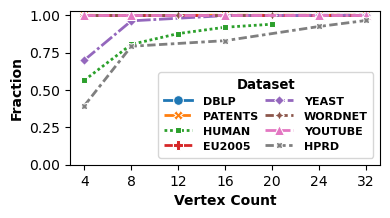

In [8]:
orbit_df = pd.read_csv("summaries/orbit-summary-reduced.csv")
orbit_df.columns = orbits + ['pattern','data']
orbit_df = orbit_df.drop(orbits_exclude, axis=1)

vcount_df = full_gf_df.groupby(["data","vertex_count"]).count().reset_index()[["data","vertex_count","pattern"]]
vcount_df.columns = ["Data", "Vertex Count", "Count"]
vcount_df = vcount_df[vcount_df["Data"] != "test"]
filtered_df = orbit_df.groupby(["data", "pattern"]).count().reset_index()[["data", "pattern"]]

fraction_df = pd.merge(filtered_df, full_gf_df[["data", "pattern", "vertex_count"]],  how='inner', left_on=["data", "pattern"], right_on=["data", "pattern"])
fraction_df = fraction_df.fillna(0).groupby(["data", "vertex_count"]).count().reset_index()
fraction_df = fraction_df[fraction_df["data"] != 'test']

fraction_df.columns = ["Data", "Vertex Count", "Filtered"]
fraction_df = pd.merge(fraction_df, vcount_df,  how='inner', left_on=["Data",	"Vertex Count"], right_on = ["Data",	"Vertex Count"])
fraction_df["Fraction"] = fraction_df["Filtered"]/fraction_df["Count"]
fraction_df.sort_values(["Vertex Count"], inplace=True)
fraction_df["Data"] = fraction_df["Data"].str.upper()
fraction_df["Vertex Count"] = fraction_df["Vertex Count"].astype(str)
fig, ax = plt.subplots(figsize=(4, 2))
sns.lineplot(data=fraction_df, x="Vertex Count", y="Fraction", hue="Data", style="Data", markers=True, palette='tab10', sort=True, ax=ax, linewidth=2)
ax.set_xlabel(ax.get_xlabel(), fontdict={'weight': 'bold'})
ax.set_ylabel(ax.get_ylabel(), fontdict={'weight': 'bold'})
plt.legend(title="Dataset", labelspacing=0.25, ncols=2, columnspacing=0.5)
plt.ylim(0)
plt.setp(ax.get_legend().get_texts(), fontsize='8', weight='bold') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='9.5', weight='bold') # for legend title
plt.savefig('plots/fraction_filtered.pdf', bbox_inches='tight')

In [9]:
plt.rcParams['lines.markersize'] = 10

In [10]:
def format_k(n):
  if n < 1000:
    return str(n)
  else:
    return str(round(n/1000.0,1))+"k"

def format_e(n):
  a = '%E' % n
  return str(round(float(a.split('E')[0].rstrip('0').rstrip('.')),2)) + 'E' + str(a.split('E')[1])


def format_f(n):
    return round(float(n), 2)

def format_frac(n):
  return str(round(float(n)/DATA_VERTEX_COUNT[DATASET],4))

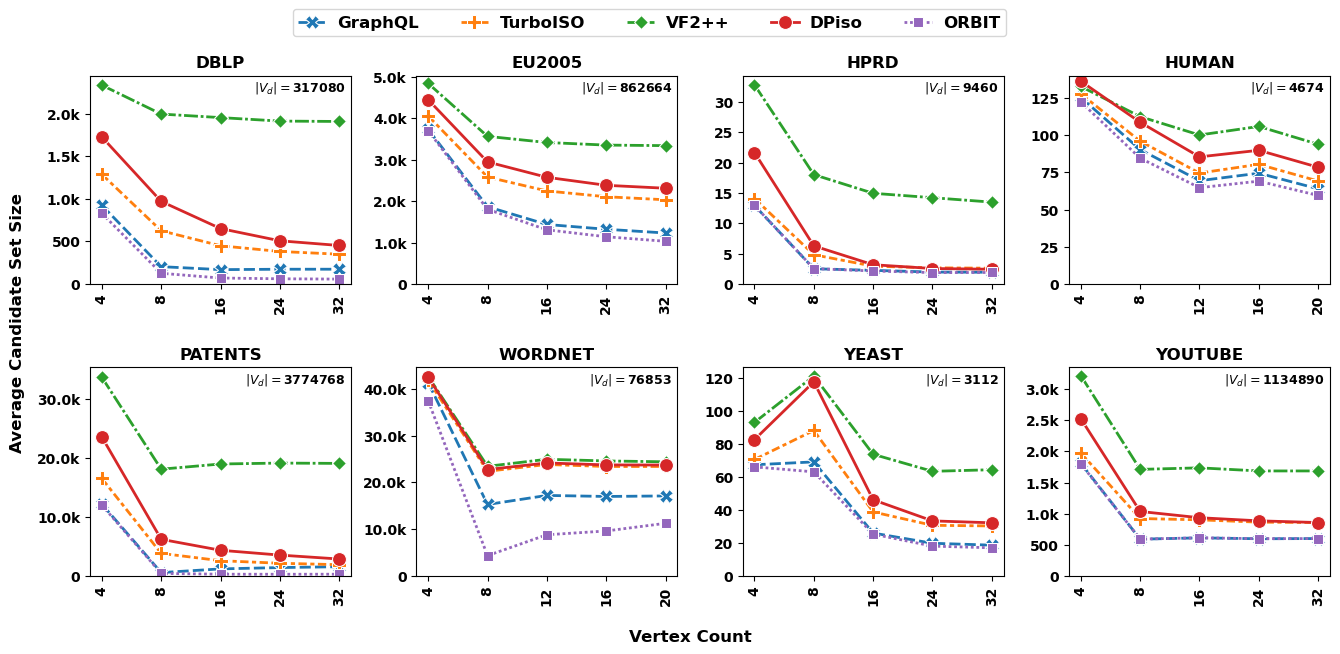

In [11]:
filter_df = pd.read_csv("summaries/filter-summary-reduced.csv")
filter_df['pattern'] = filter_df['pattern'].str.split('.').str[0]
filter_df['filter'] = filter_df['filter'].str.replace('GLFP','ORBIT')
filter_df['filter'] = filter_df['filter'].str.replace('GQL','GraphQL')
filter_df['filter'] = filter_df['filter'].str.replace('TSO','TurboISO')
filter_df['filter'] = filter_df['filter'].str.replace('NLF','VF2++')
filter_df = filter_df[~filter_df['filter'].isin(['LDF', 'CFL'])]
filter_df = pd.merge(filter_df, full_gf_df[["data", "pattern", "vertex_count"]],  how='inner', left_on=["data", "pattern"], right_on=["data", "pattern"])
filter_df.columns = ["data",	"pattern",	"Filter",	"cs_mean",	"cs_std",	"vertex_count"]
fig = plt.figure(figsize=(16, 6.5))
fig.subplots_adjust(hspace=0.4, wspace=0.25)
i = 1
for DATASET in DATASETS:
  t_df = filter_df[filter_df["data"] == DATASET]
  t_df = t_df.drop(["data", "pattern"], axis=1)
  t_df.sort_values(['Filter', 'vertex_count'], inplace=True)
  t_df['vertex_count'] = t_df['vertex_count'].astype(str)
  ax = fig.add_subplot(2, 4, i)
  g = sns.lineplot(data=t_df, x="vertex_count", y="cs_mean", hue="Filter", palette='tab10', hue_order = ['GraphQL', 'TurboISO', 'VF2++', 'DPiso', 'ORBIT'], errorbar=None, ax=ax, style="Filter", markers=True, linewidth = 2)
  plt.ylim(0)
  g.set_yticklabels([format_k(int(j)) for j in g.get_yticks()], size=10, weight='bold')
  g.set_xticklabels([str(j) for j in t_df['vertex_count'].unique()], size=10, weight='bold')
  plt.xlabel(None)
  plt.ylabel(None)
  plt.title(DATASET.upper(), fontsize=12, fontweight='bold')
  plt.text(0.98, 0.98, "$|V_d|=$"+str(DATA_VERTEX_COUNT[DATASET]), ha='right', va='top', transform=g.transAxes, weight='bold', fontsize=9)
  plt.xticks(rotation=90)
  if i!=1:
    plt.legend([],[], frameon=False)
  else:
    plt.legend(loc="upper left", ncol=5, bbox_to_anchor=(0.75, 1.35), columnspacing=3)
    plt.setp(ax.get_legend().get_texts(), fontsize='12', weight='bold')
  i+=1
fig.text(0.5, 0.01, 'Vertex Count', ha='center', weight='bold', fontsize=12)
fig.text(0.075, 0.5, 'Average Candidate Set Size', va='center', rotation='vertical', weight='bold', fontsize=12)
plt.savefig('plots/filter_comparision_vertices.pdf', bbox_inches='tight')

In [12]:
filter_summary = filter_df.drop(["pattern", "vertex_count", "cs_std"], axis=1).groupby(["data", "Filter"]).mean().reset_index().pivot(columns="Filter", index="data", values="cs_mean").reset_index()
filter_summary["DPiso"] = filter_summary["DPiso"]/filter_summary["ORBIT"]
filter_summary["GraphQL"] = filter_summary["GraphQL"]/filter_summary["ORBIT"]
filter_summary["TurboISO"] = filter_summary["TurboISO"]/filter_summary["ORBIT"]
filter_summary["VF2++"] = filter_summary["VF2++"]/filter_summary["ORBIT"]
filter_summary.describe().drop(["ORBIT"], axis=1).loc[['mean', 'min', 'max']]

Filter,DPiso,GraphQL,TurboISO,VF2++
mean,2.344935,1.247645,1.859966,5.093545
min,1.269773,1.000433,1.132573,1.411860
max,4.709180,1.653845,3.350739,12.551031


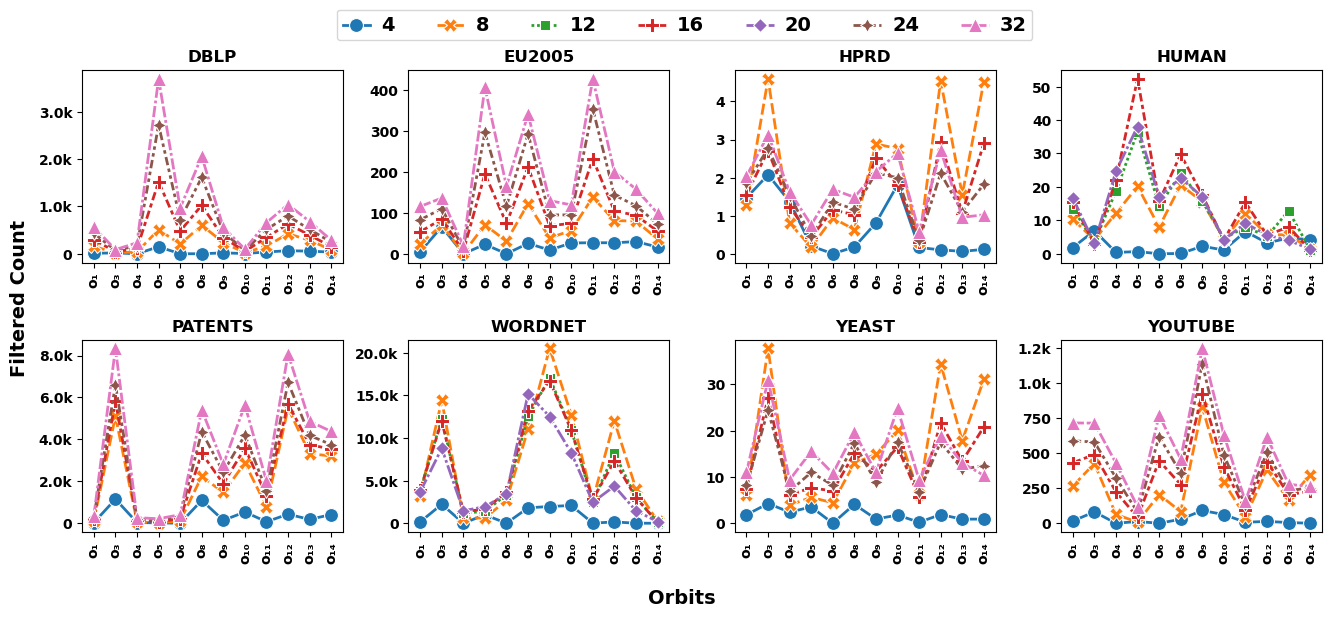

In [13]:
fig = plt.figure(figsize=(16, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.25)

i = 1
for DATASET in DATASETS:
  gf_df = full_gf_df[full_gf_df["data"] == DATASET]
  gf_df = gf_df[['pattern', 'vertex_count', 'edge_count', 'diameter', 'density']]

  append_df = orbit_df[orbit_df["data"] == DATASET]
  append_df = append_df.drop(["data"], axis=1)

  f_df = append_df.merge(gf_df, how="inner").fillna(0).drop(['pattern'], axis=1).groupby([to_group]).mean().reset_index().drop(to_drop, axis=1)
  melted_f_df = pd.melt(f_df, id_vars=[to_group])
  melted_f_df.columns = ["Vertex Count", "Orbit", "Count"]
  for product in cross_product:
    combination_exists = (melted_f_df['Vertex Count'] == product[0]) & (melted_f_df['Orbit'] == product[1])
    if not combination_exists.any():
        melted_f_df = pd.concat([melted_f_df, pd.DataFrame([{'Vertex Count': product[0], 'Orbit': product[1], 'Count': np.nan}])], ignore_index=True)

  melted_f_df = melted_f_df[~melted_f_df['Orbit'].isin(orbits_exclude)]

  ax = fig.add_subplot(2, 4, i)
  g = sns.lineplot(data=melted_f_df, x="Orbit", y="Count", hue="Vertex Count", palette='tab10', ax=ax, style="Vertex Count", markers=True, linewidth = 2)
  g.set_yticklabels([format_k(int(j)) for j in g.get_yticks()], size=10, weight='bold')
  g.set_xticklabels([str(j) for j in reduced_orbit_unicode], size=10, weight='bold')

  plt.xlabel(None)
  plt.ylabel(None)
  plt.title(DATASET.upper(), fontsize=12, fontweight='bold')
  plt.xticks(rotation=90)
  if i!=1:
    plt.legend([],[], frameon=False)
  else:
    plt.legend(loc="upper left", ncol=7, bbox_to_anchor=(0.95, 1.35), columnspacing=3)
    plt.setp(ax.get_legend().get_texts(), fontsize='14', weight='bold') # for legend text
  i+=1

fig.text(0.5, -0.01, 'Orbits', ha='center', weight='bold', fontsize=14)
fig.text(0.08, 0.5, 'Filtered Count', va='center', rotation='vertical', weight='bold', fontsize=14)
plt.savefig('plots/filter_count_by_orbit.pdf', bbox_inches='tight')

In [14]:
df_order = pd.read_csv("summaries/summary-order.csv")

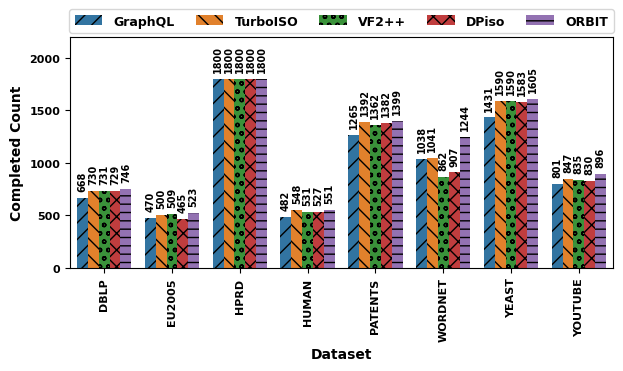

In [15]:
t_df = df_order.groupby(["Data", "Order"]).count().reset_index()
t_df.loc[t_df['Order'] == "GraphQL", 'Pattern'] = t_df["Pattern"] - 0.1*t_df["Pattern"]
t_df.loc[t_df['Data'] == "hprd", 'Pattern'] = 1800
t_df["Pattern"] = t_df["Pattern"].astype(int)
plt.figure(figsize=(7, 3))
ax = sns.barplot(data=t_df, x="Data", y="Pattern", hue="Order", palette='tab10', errorbar=None, hue_order = ['GraphQL', 'TurboISO', 'VF2++', 'DPiso', 'ORBIT'])
plt.ylim((0, 2200))

hatches = ['//']*8 + ['\\\\']*8 +['oo']*8 + ['xx']*8 + ['--']*8 + ['//','\\\\','oo','xx','--']
for i,thisbar in enumerate(ax.patches):
  thisbar.set_hatch(hatches[int(i)])

for container in ax.containers:
  ax.bar_label(container, rotation=90, fontsize=7, padding=5, label_type='edge', weight='bold')
ax.set_yticklabels([int(j) for j in ax.get_yticks()], size=8, weight='bold')
ax.set_xticklabels([str(j.upper()) for j in DATASETS], size=8, weight='bold')
plt.xlabel("Dataset", size=10, weight='bold')
plt.ylabel("Completed Count", size=10, weight='bold')
plt.xticks(rotation=90)
#sns.move_legend(ax, "upper left",)
plt.legend(loc="upper left", ncol=5,  bbox_to_anchor=(-0.015, 1.15), columnspacing=1.505)
plt.setp(ax.get_legend().get_texts(), fontsize='9', weight='bold') # for legend text
plt.savefig('plots/order_completed_count.pdf', bbox_inches='tight')

In [16]:
full_gf_df = full_gf_df[['data', 'pattern', 'vertex_count']]
full_gf_df.columns = ["Data", "Pattern", "Vertex Count"]

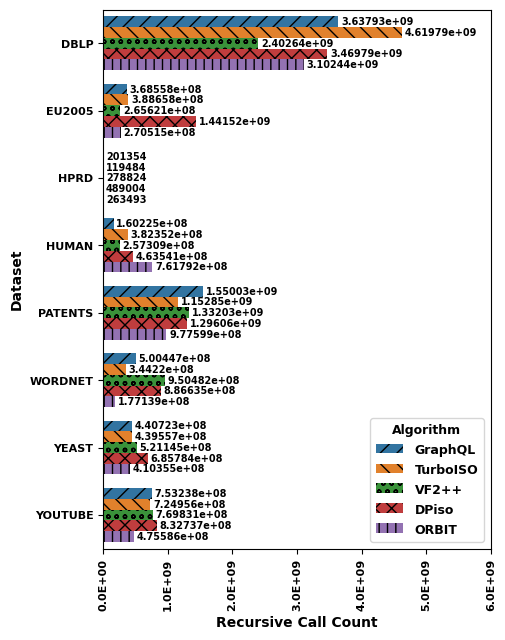

In [17]:
df_pivot = df_order.pivot(index=["Data", "Pattern"], columns=["Order"], values="Call Count").reset_index().dropna()
completed = pd.merge(df_pivot, full_gf_df, how='inner', on=["Data", "Pattern"]).drop(["Pattern"], axis=1).groupby(["Data", "Vertex Count"]).mean().reset_index()
completed_melted = pd.melt(completed, id_vars=['Data', 'Vertex Count'])
completed_melted.columns = ["Data", "Vertex Count", "Order", "Call Count"]
completed_melted.loc[completed_melted['Order'] == "GraphQL", 'Call Count'] = completed_melted["Call Count"] + 0.45*completed_melted["Call Count"]
completed_melted.loc[completed_melted['Order'].isin(["TurboISO"]) & completed_melted['Data'].isin(["yeast"]), 'Call Count'] = completed_melted["Call Count"] + 0.1*completed_melted["Call Count"]
completed_melted.sort_values(["Data", "Vertex Count"], inplace=True)
completed_melted["Vertex Count"] = completed_melted["Vertex Count"].astype(str)

plt.figure(figsize=(5, 7))
ax = sns.barplot(data=completed_melted, y="Data", x="Call Count", hue="Order", palette='tab10', errorbar=None, hue_order = ['GraphQL', 'TurboISO', 'VF2++', 'DPiso', 'ORBIT'])
plt.xlim((0, 6.0e+9))
hatches = ['//']*8 + ['\\\\']*8 +['oo']*8 + ['xx']*8 + ['||']*8 + ['//','\\\\','oo','xx','||']
for i,thisbar in enumerate(ax.patches):
  thisbar.set_hatch(hatches[int(i)])

for container in ax.containers:
  ax.bar_label(container, rotation=0, fontsize=7, weight='bold', padding=2, label_type='edge')

ax.set_xticklabels([format_e(int(j)) for j in ax.get_xticks()], size=8, weight='bold')
ax.set_yticklabels([str(j.upper()) for j in DATASETS], size=8, weight='bold')
plt.xlabel("Recursive Call Count", size=10, weight='bold')
plt.ylabel("Dataset", size=10, weight='bold')
plt.xticks(rotation=90)
plt.legend(title="Algorithm")
plt.setp(ax.get_legend().get_texts(), fontsize='9', weight='bold')
plt.setp(ax.get_legend().get_title(), fontsize='9', weight='bold')

plt.savefig('plots/order_calls_count_by_dataset.pdf', bbox_inches='tight')

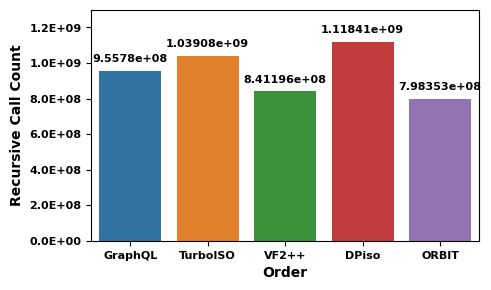

In [18]:
plt.figure(figsize=(5, 3))
ax = sns.barplot(data=completed_melted, x="Order", y="Call Count", palette='tab10', hue="Order", legend=False, errorbar=None, order = ['GraphQL', 'TurboISO', 'VF2++', 'DPiso', 'ORBIT'], hue_order = ['GraphQL', 'TurboISO', 'VF2++', 'DPiso', 'ORBIT']) #, ax=ax, marker='X', linewidth = 2)
plt.ylim((0, 1.3e+9))
for container in ax.containers:
  ax.bar_label(container, rotation=0, fontsize=8, padding=5, label_type='edge', weight='bold')
ax.set_yticklabels([format_e(int(j)) for j in ax.get_yticks()], size=8, weight='bold')
ax.set_xticklabels([str(j) for j in ['GraphQL', 'TurboISO', 'VF2++', 'DPiso', 'ORBIT']], size=8, weight='bold')
plt.ylabel("Recursive Call Count", size=10, weight='bold')
plt.xlabel("Order", size=10, weight='bold')

plt.savefig('plots/order_calls_count.pdf', bbox_inches='tight')

In [19]:
order_summary = completed_melted.drop(["Vertex Count"], axis=1).groupby(["Data", "Order"]).mean().reset_index().pivot(index="Data", columns="Order", values="Call Count").reset_index().dropna()
order_summary.describe()

Order,DPiso,GraphQL,ORBIT,TurboISO,VF2++
count,8.000000e+00,8.000000e+00,8.000000e+00,8.000000e+00,8.000000e+00
mean,1.134570e+09,9.264192e+08,7.719612e+08,1.006563e+09,8.124171e+08
std,1.046353e+09,1.191919e+09,9.923207e+08,1.497649e+09,7.719373e+08
min,4.890036e+05,2.013542e+05,2.634933e+05,1.194838e+05,2.788237e+05
25%,6.302229e+08,3.164747e+08,2.471708e+08,3.728192e+08,2.635431e+08
50%,8.596861e+08,4.705845e+08,4.429705e+08,4.141075e+08,6.454882e+08
75%,1.332424e+09,9.524357e+08,8.157439e+08,8.319295e+08,1.045870e+09
max,3.469795e+09,3.637934e+09,3.102441e+09,4.619789e+09,2.402635e+09


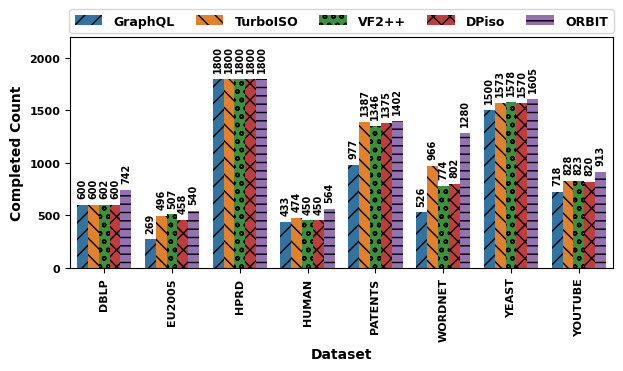

In [20]:
order_df = pd.read_csv("summaries/summary-enumeration.csv")
h_order = ['GraphQL', 'TurboISO', 'VF2++', 'DPiso', 'ORBIT']
plt.figure(figsize=(7, 3))
ax = sns.barplot(data=order_df.groupby(["Data", "Algorithm"]).count().reset_index(), order=DATASETS,x="Data", y="Pattern", hue="Algorithm", hue_order = h_order)
plt.ylim((0, 2200))

hatches = ['//']*8 + ['\\\\']*8 +['oo']*8 + ['xx']*8 + ['--']*8 + ['//','\\\\','oo','xx','--']
for i,thisbar in enumerate(ax.patches):
  thisbar.set_hatch(hatches[int(i)])

for container in ax.containers:
  ax.bar_label(container, rotation=90, fontsize=7, padding=5, label_type='edge', weight='bold')

ax.set_yticklabels([int(j) for j in ax.get_yticks()], size=8, weight='bold')
ax.set_xticklabels([str(j.upper()) for j in DATASETS], size=8, weight='bold')
plt.xlabel("Dataset", size=10, weight='bold')
plt.ylabel("Completed Count", size=10, weight='bold')
plt.legend(loc="upper left", ncol=5,  bbox_to_anchor=(-0.015, 1.15), columnspacing=1.505)
plt.setp(ax.get_legend().get_texts(), fontsize='9', weight='bold')
plt.xticks(rotation=90)
plt.savefig('plots/runtime_completed_count.pdf', bbox_inches='tight')

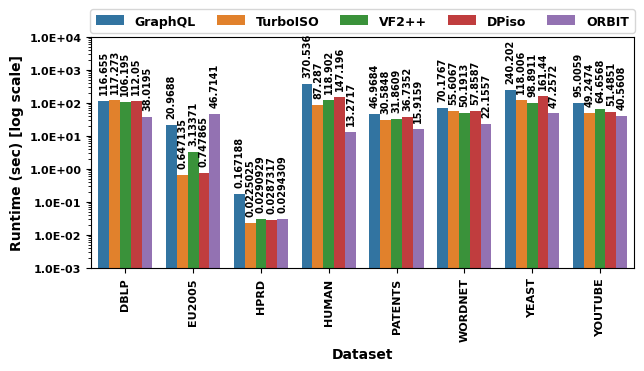

In [21]:
completed = pd.merge(df_pivot, full_gf_df, how='inner', on=["Data", "Pattern"])
completed_full = pd.merge(order_df, completed[["Data", "Pattern", "Vertex Count"]], how='inner', on=["Data", "Pattern"])
plt.figure(figsize=(7, 3))
ax = sns.barplot(data=completed_full, x="Data", y="Total time", hue="Algorithm", errorbar=None, hue_order = h_order)
for container in ax.containers:
  ax.bar_label(container, rotation=90, fontsize=7, padding=5, label_type='edge', weight='bold')
plt.yscale('log')
plt.ylim((0.001, 10000))
ax.set_yticklabels([format_e(j) for j in ax.get_yticks()], size=8, weight='bold')
ax.set_xticklabels([str(j.upper()) for j in DATASETS], size=8, weight='bold')
plt.xlabel("Dataset", size=10, weight='bold')
plt.ylabel("Runtime (sec) [log scale]", size=10, weight='bold')
plt.legend(loc="upper left", ncol=5,  bbox_to_anchor=(-0.015, 1.15), columnspacing=1.505)
plt.setp(ax.get_legend().get_texts(), fontsize='9', weight='bold')
plt.xticks(rotation=90)
plt.savefig('plots/runtime_baseline_comparision_log.pdf', bbox_inches='tight')

In [22]:
runtime_summary = completed_full.drop(["Pattern"], axis=1).groupby(["Data", "Algorithm"]).mean().reset_index()[["Data", "Algorithm", "Total time"]].pivot(columns="Algorithm", index="Data", values="Total time").reset_index()
runtime_summary["DPiso"] = runtime_summary["DPiso"]/runtime_summary["ORBIT"]
runtime_summary["GraphQL"] = runtime_summary["GraphQL"]/runtime_summary["ORBIT"]
runtime_summary["TurboISO"] = runtime_summary["TurboISO"]/runtime_summary["ORBIT"]
runtime_summary["VF2++"] = runtime_summary["VF2++"]/runtime_summary["ORBIT"]
runtime_summary.describe().drop(["ORBIT"], axis=1).loc[['mean', 'min', 'max']]

Algorithm,DPiso,GraphQL,TurboISO,VF2++
mean,3.079432,6.332601,2.322829,2.595222
min,0.016009,0.448874,0.013853,0.067083
max,11.090973,27.919296,6.576937,8.959114


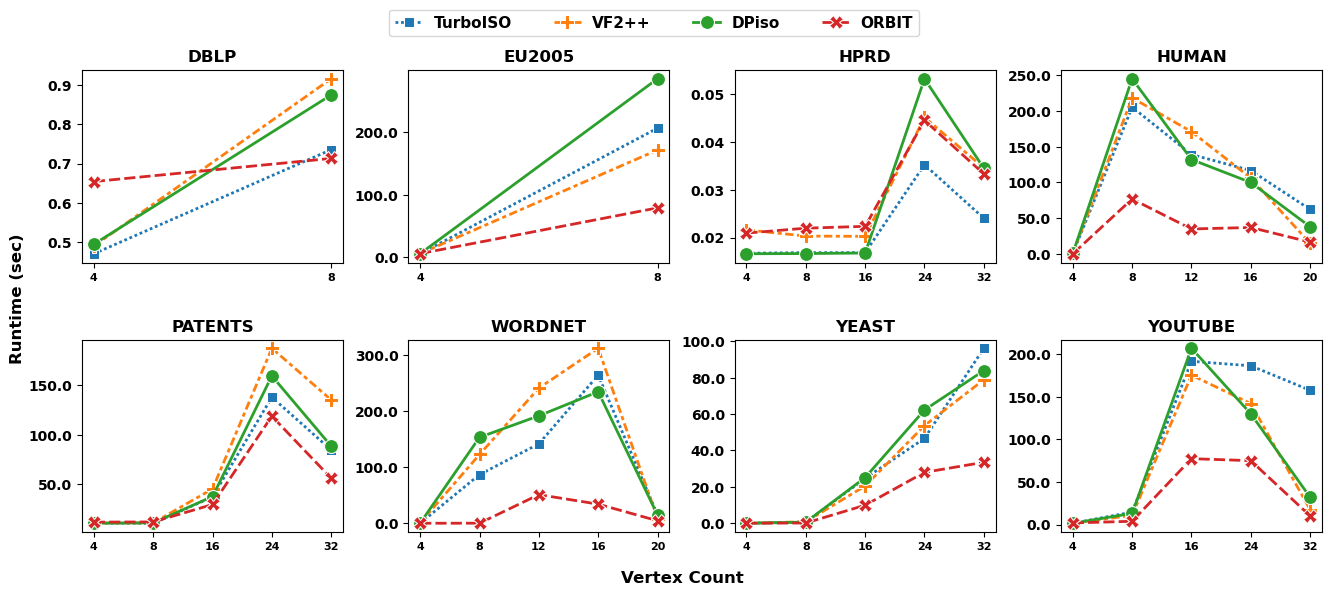

In [23]:
t_df = order_df[order_df["Algorithm"] != "GraphQL"]
df_pivot = t_df[["Data", "Pattern", "Algorithm", "Total time"]].pivot(index=["Data", "Pattern"], columns=["Algorithm"], values="Total time").reset_index().dropna()
completed = pd.merge(df_pivot, full_gf_df, how='inner', on=["Data", "Pattern"])
completed_full = pd.merge(order_df, completed[["Data", "Pattern", "Vertex Count"]], how='inner', on=["Data", "Pattern"])


fig = plt.figure(figsize=(16, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.25)

i = 1
for DATASET in DATASETS:
  t_df = completed_full[completed_full["Data"] == DATASET].drop(["Data"], axis=1)
  t_df = t_df[t_df["Algorithm"] != "GraphQL"]
  t_df.sort_values(["Vertex Count", "Algorithm"], inplace=True)
  t_df["Vertex Count"] = t_df["Vertex Count"].astype(str)
  ax = fig.add_subplot(2, 4, i)
  g = sns.lineplot(data=t_df, hue="Algorithm", y="Total time", x="Vertex Count", linewidth=2, palette='tab10', errorbar=None, hue_order=[ele for ele in h_order if ele != "GraphQL"], style="Algorithm", markers=True, ax=ax)
  g.set_yticklabels([round(float(j),3) for j in g.get_yticks()], size=10, weight='bold')
  g.set_xticklabels([str(j) for j in t_df["Vertex Count"].unique()], size=8, weight='bold')

  plt.xlabel(None)
  plt.ylabel(None)
  plt.title(DATASET.upper(), fontsize=12, fontweight='bold')

  if i!=3:
    plt.legend([],[], frameon=False)
  else:
    #sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.15))
    plt.legend(loc="upper left", ncol=7, bbox_to_anchor=(-1.35, 1.35), columnspacing=3)
    plt.setp(ax.get_legend().get_texts(), fontsize='11', weight='bold') # for legend text
  i+=1
fig.text(0.5, 0.025, 'Vertex Count', ha='center', weight='bold', fontsize=12)
fig.text(0.08, 0.5, 'Runtime (sec)', va='center', rotation='vertical', weight='bold', fontsize=12)
plt.savefig('plots/runtime_baseline_comparision_by_vertex.pdf', bbox_inches='tight')

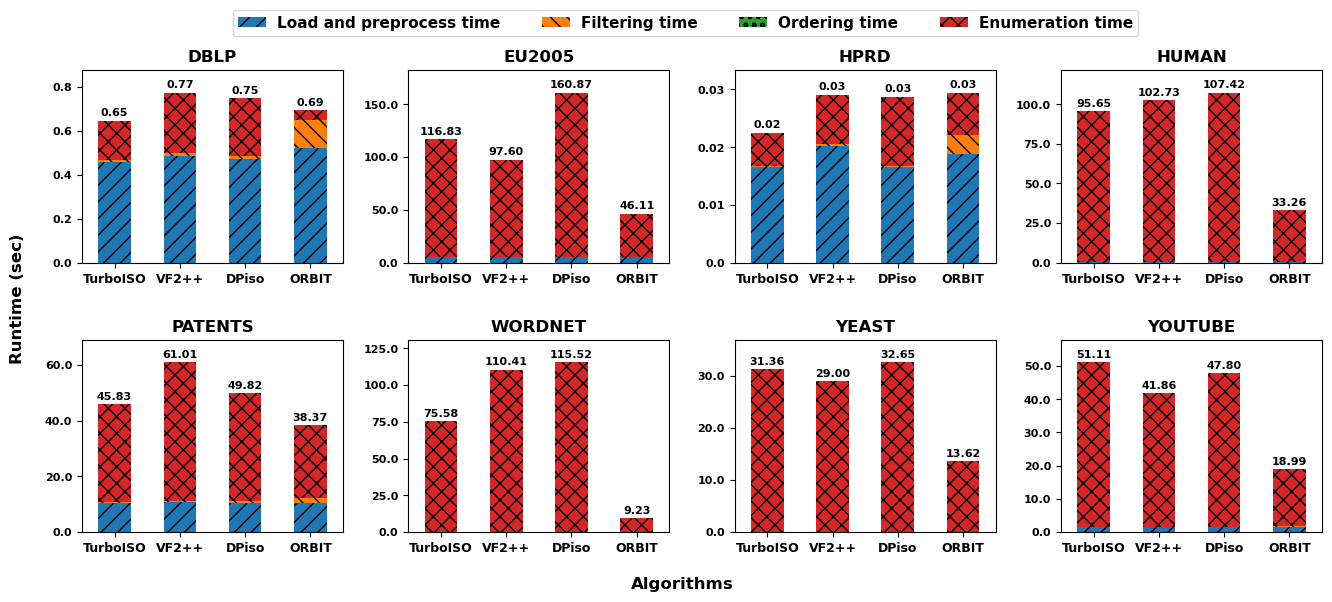

In [24]:
fig = plt.figure(figsize=(16, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.25)

i = 1
for DATASET in DATASETS:
  ax = fig.add_subplot(2, 4, i)
  t_df = completed_full[completed_full['Data'] == DATASET].drop(['Data', 'Pattern', 'Vertex Count', 'Total time', '#Embeddings'], axis=1).groupby(['Algorithm']).mean().reset_index().set_index('Algorithm').drop(index=['GraphQL']).reindex([h for h in h_order if h != "GraphQL"])
  t_df.plot(kind='bar', stacked=True, ax=ax, logy=False)
  plt.set_cmap('tab10')
  plt.xlabel(None)
  plt.ylabel(None)
  plt.title(DATASET.upper(), fontsize=12, fontweight='bold')
  plt.xticks(rotation=0)
  ax.set_ylim(0, ax.get_ylim()[1]+0.08*ax.get_ylim()[1])
  hatches = ['//', '\\\\', 'oo', 'xx', '--','OO']
  for j,thisbar in enumerate(ax.patches):
    thisbar.set_hatch(hatches[int(j/4)])

  for container in ax.containers:
    if container.get_label() == "Enumeration time":
      ax.bar_label(container, fmt='%0.2f', fontsize=8, padding=2, label_type='edge', weight='bold')
  ax.set_yticklabels([round(float(j),3) for j in ax.get_yticks()], size=8, weight='bold')
  ax.set_xticklabels([str(j) for j in t_df.index.unique()], size=9, weight='bold')
  if i!=3:
    plt.legend([],[], frameon=False)
  else:
    #sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.15))
    plt.legend(loc="upper left", ncol=4, bbox_to_anchor=(-1.95, 1.35), columnspacing=3)
    plt.setp(ax.get_legend().get_texts(), fontsize='11', weight='bold') # for legend text
  i+=1

fig.text(0.5, 0.015, 'Algorithms', ha='center', weight='bold', fontsize=12)
fig.text(0.08, 0.5, 'Runtime (sec)', va='center', rotation='vertical', weight='bold', fontsize=12)
plt.savefig('plots/runtime_baseline_comparision_stacked.pdf', bbox_inches='tight')

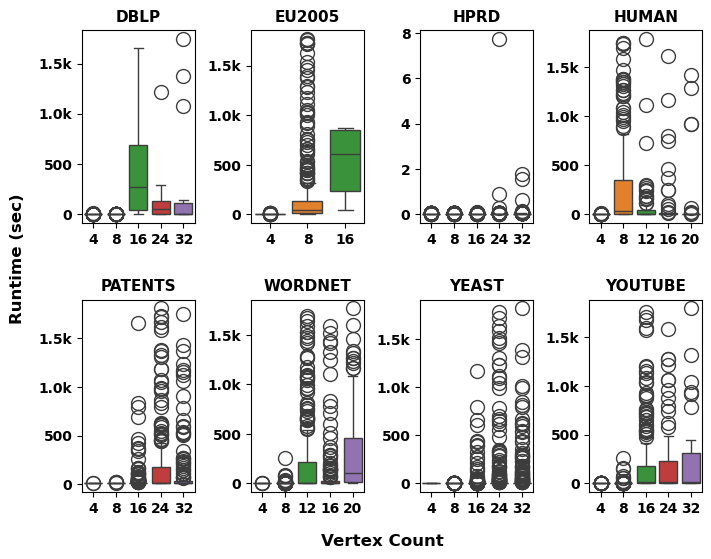

In [25]:
orbit_complete = pd.merge(order_df[order_df["Algorithm"] == "ORBIT"], full_gf_df, how='inner', on=["Data", "Pattern"])
orbit_complete.sort_values(["Vertex Count"], inplace=True)
orbit_complete["Vertex Count"] = orbit_complete["Vertex Count"].astype(str)

fig = plt.figure(figsize=(8, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.5)

i = 1
for DATASET in DATASETS:
  ax = fig.add_subplot(2, 4, i)
  g = sns.boxplot(data=orbit_complete[orbit_complete["Data"] == DATASET], x="Vertex Count", y="Total time", palette='tab10', hue="Vertex Count", legend=False)
  plt.xlabel(None)
  plt.ylabel(None)
  plt.title(DATASET.upper(), fontsize=11, fontweight='bold')
  g.set_yticklabels([format_k(int(j)) for j in g.get_yticks()], size=10, weight='bold')
  g.set_xticklabels([j for j in orbit_complete[orbit_complete["Data"] == DATASET]["Vertex Count"].unique()], size=10, weight='bold')
  i+=1
fig.text(0.5, 0.02, 'Vertex Count', ha='center', weight='bold', fontsize=12)
fig.text(0.035, 0.5, 'Runtime (sec)', va='center', rotation='vertical', weight='bold', fontsize=12)
plt.savefig('plots/runtime_orbit_distribution.pdf', bbox_inches='tight')